Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Согласно поставленной задачи, нам нужно качественно и быстро определять предпологаемую цену автомобиля. Для того что бы деллать это качественно нужно хорошо предобработать данные и удалить ошибочные или не корректные данные. При анализе будем руводствоваться общепринятыми стандартами или известными ззначениями.
1. Обще ознакомление с данными
2. Анализ целевого признака
3. Изучение признаков, удаление некачественных данных
    - Категориальные 
        
    - Количественные
4. Анализ пропусков
5. Формирование датасетов для обучения.
    

# 1. Подготовка данных

#import

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from catboost import Pool, cv
import time
import lightgbm as lgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from datetime import timedelta
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Shad/car_price/autos.csv')

In [5]:
#check datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.shape

(354369, 16)

In [7]:
# просмотр данных
df.head(10) 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [8]:
# Приведем название признаков к нижнему регистру
df.columns = map(str.lower, df.columns)
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

### Анализ  целевого признака

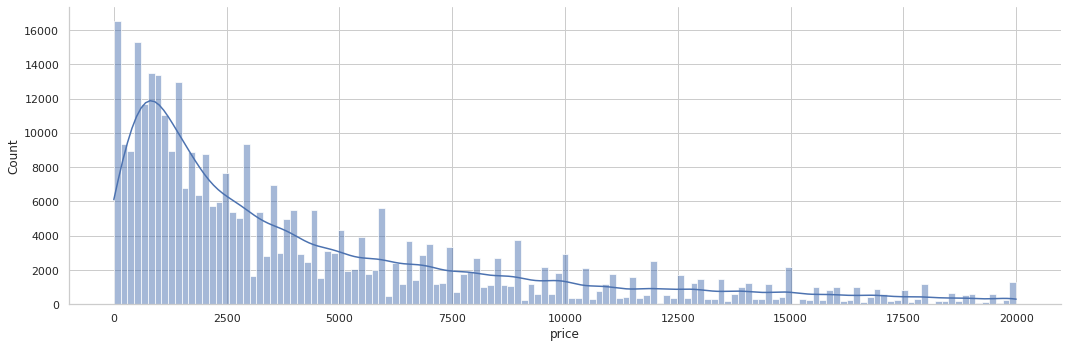

In [9]:
sns.set_theme(style="whitegrid")
g = sns.displot(data=df.price, aspect=3,kde=True).set_titles("Price")

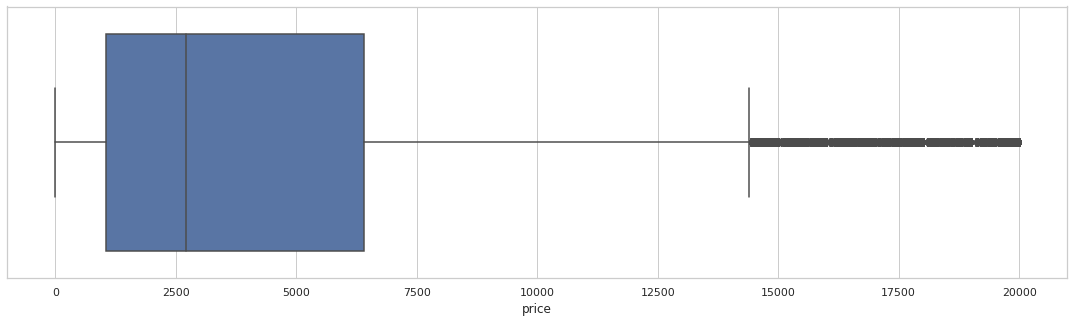

In [10]:
plt.figure(figsize=(19, 5))
sns.boxplot(x=df.price)

Много нулевых занчений и близких к 0 , удалим. Для нашей задачи нулевая стоимость авто не годится, будем считать, что минимальная стоимость авто 100 евро, Максимальную цену оставим без изменений.Далее возможно внес корректировки. Есть предположение, что когда продавец заполняет поле, 0-й или другой не  корректной величиной (1,2,3 999 и т.д.), то он просто не знает этого параметра. 

In [11]:
df.drop(df.loc[df['price'] < 100].index, inplace=True)

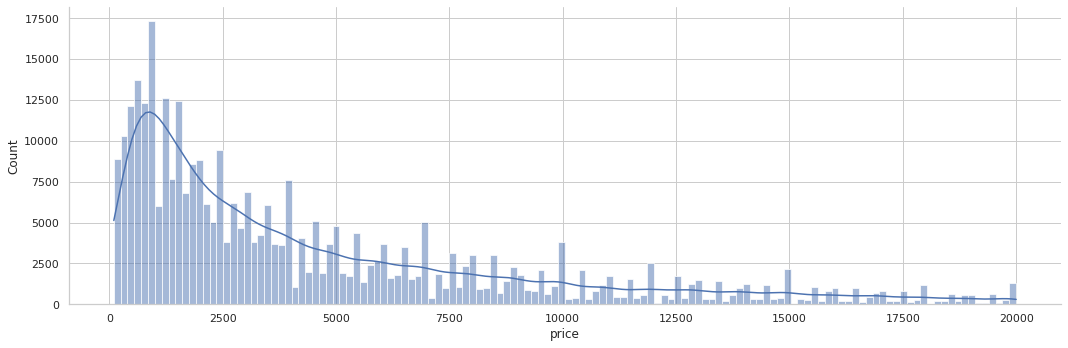

In [12]:
g = sns.displot(data=df.price, aspect=3,kde=True).set_titles("Price")

In [13]:
df['price'].describe()

count    341055.000000
mean       4588.861052
std        4514.844700
min         100.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

Перейдем к признакам, проверим сначала категориальные, затем колличественные избавимся от выбросов и некорректно указанных данных, а после уже проверим кол-во пустых значений.

In [14]:
df.head(5)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Проверим категориальные признаки 

#### Коропка передач

In [15]:
df.gearbox.unique()

array(['manual', 'auto', nan], dtype=object)

#### Модель автомобиля

In [16]:
df.model.unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'other', 'c4', 'civic',
       'transporter', 'punto', 'e_klasse', 'clio', 'kadett', 'kangoo',
       'one', 'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8',
       'jetta', 'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156',
       'escort', 'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia',
       'combo', 'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk',
       '7er', '80', '147', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', 'i_reihe',
       'espace', 'sharan', '6_reihe', 'panda', 'up', 'seicento', 'ceed',
       '5_reihe', 'yeti', 'octavia', 'mii', 'rx_reihe', '6er', 'modus',
     

#### Тип топлива

In [17]:
df.fueltype.unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

#### Производитель

In [18]:
df.brand.unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'alfa_romeo', 'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki',
       'lancia', 'sonstige_autos', 'toyota', 'chevrolet', 'dacia',
       'daihatsu', 'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche',
       'saab', 'trabant', 'land_rover', 'lada'], dtype=object)

Похоже что нечего критичного кроме nan нет. 

### Проверим количественные признаки

#### Год регистрации автомобиля 

Печально, много неверных данных.

In [19]:
df.registrationyear.describe()

count    341055.000000
mean       2003.955303
std          69.811742
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

In [20]:
#найдем реальный минимальный год регистрации автомобиля
df.query('registrationyear < 1999 and registrationyear >1800')['registrationyear'].min()


1910

In [21]:
# Удалим года регистрации со значениями  меньше 1910 и старше 2016 года 
df.drop(df.query('registrationyear > 2016 or registrationyear < 1910').index,inplace=True)

In [22]:
df.registrationyear.describe()

count    327325.000000
mean       2002.624749
std           6.860012
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registrationyear, dtype: float64

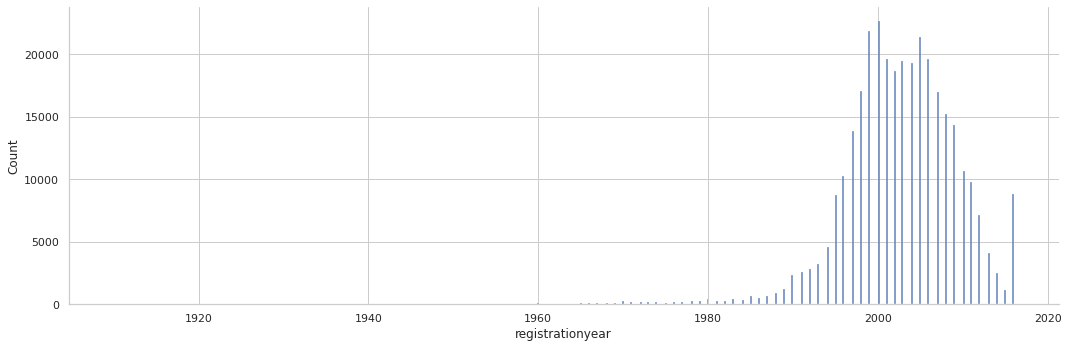

In [23]:
sns.displot(df.registrationyear,aspect=3)

Теперь посмотрим на мощность

In [24]:
df.power.max()

20000

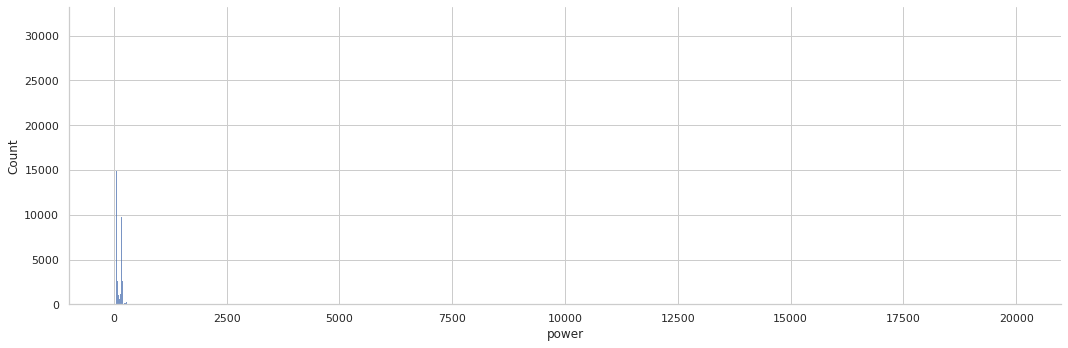

In [25]:
sns.displot(df.power,aspect=3)

In [26]:
df.power.describe()

count    327325.000000
mean        112.338596
std         185.284657
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

Не машины, а ракеты. Мощность среднестатистического автомобиля схожа с нашим средним 111 л.с, есть автобусы с мощностью до 500 л.с. Удалим данные с мощностью более 700 л.с. - это уже уникальные ТС.
У нас есть еще нулевые значения мощности. Вероятно здесь похожая ситуация как и с ценой автомобиля.
За минимально возможную величину возьмем 9 л.с. 

In [27]:
df.drop(df.query('power > 700 or power < 9').index, inplace=True)

In [28]:
df.power.describe()

count    295219.000000
mean        120.767440
std          54.035429
min           9.000000
25%          76.000000
50%         111.000000
75%         150.000000
max         700.000000
Name: power, dtype: float64

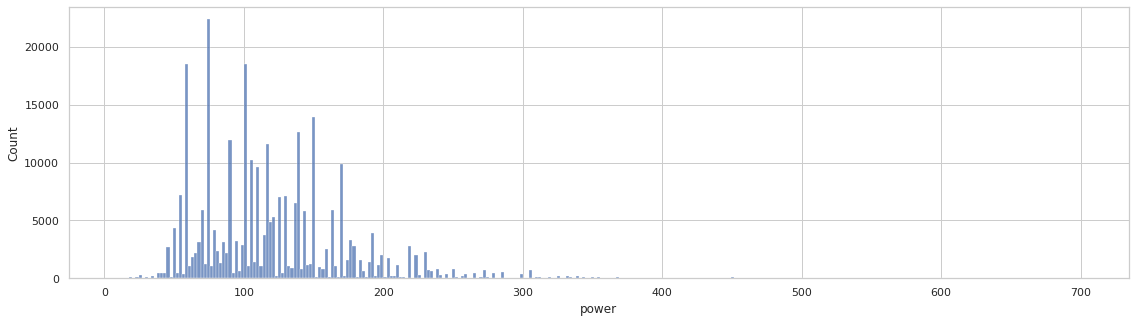

In [29]:
plt.figure(figsize=(19,5))
sns.histplot(df.power)

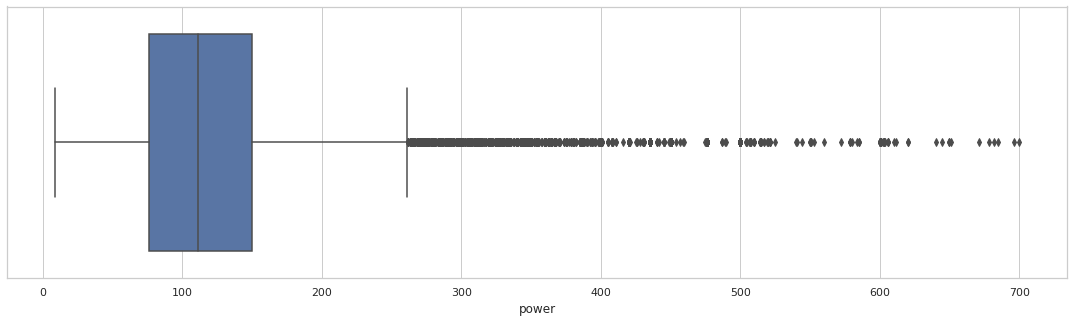

In [30]:
plt.figure(figsize=(19,5))
sns.boxplot(data=df, x='power')

#### Пробег

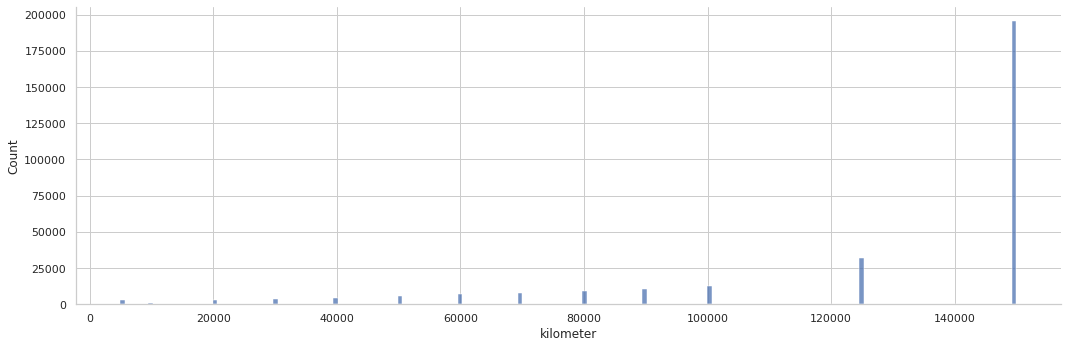

In [31]:
sns.displot(df.kilometer,aspect=3)

In [32]:
df.kilometer.describe()

count    295219.000000
mean     128303.090248
std       36714.971982
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Признак километража очень странно выглядит, вероятно есть операция округления значений при подаче обьявлений

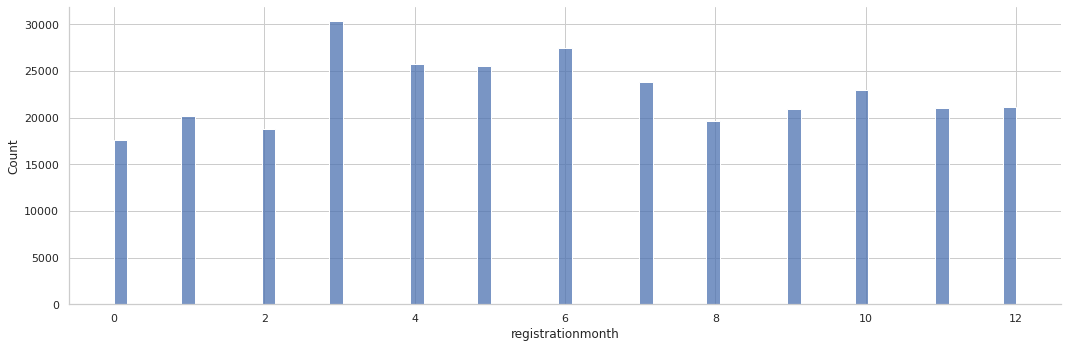

In [33]:
sns.displot(df.registrationmonth,aspect=3)

Нулевой месяц, возможно это авто снятое с учета, тогда registrationyear скорее год выпуска. Пока оставим без изменений.

In [34]:
df.shape

(295219, 16)

In [35]:
# check for NuN or empty
df.isna().mean()


datecrawled          0.000000
price                0.000000
vehicletype          0.036654
registrationyear     0.000000
gearbox              0.017811
power                0.000000
model                0.037061
kilometer            0.000000
registrationmonth    0.000000
fueltype             0.051904
brand                0.000000
notrepaired          0.143869
datecreated          0.000000
numberofpictures     0.000000
postalcode           0.000000
lastseen             0.000000
dtype: float64

Пропуски: 
- vehicletype - тип кузова 9%
- gearbox  тип КП 4%
- model - 4% 
- fueltype - тип топлива 8%
- notrepaired - признак ремонта 18%

Метрики категориальные. Попробуем сделать 2 дата сета.
 1. полностью удалим данные,  хотя удалять 15% это совсем не правильно. Но в рамках эксперемента можно)
 2. заполним пустышки "other", а затем сделаем процедуру "OrdinalEncoder"
 

### Временные признаки, дата

In [36]:
df.head(1)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


У нас есть три временных признака, дата скачивания анкеты (datecrawled), дата создания обьявления (datecreated)  и дата последней активности (lastseen) посмотрим на самые старые или новые обьявления. 

In [37]:
df[['datecrawled', 'datecreated', 'lastseen']].min()

datecrawled    2016-03-05 14:06:22
datecreated    2015-03-20 00:00:00
lastseen       2016-03-05 14:15:08
dtype: object

In [38]:
df[['datecrawled', 'datecreated', 'lastseen']].max()

datecrawled    2016-04-07 14:36:58
datecreated    2016-04-07 00:00:00
lastseen       2016-04-07 14:58:51
dtype: object

In [39]:
df['yearcreated'] = pd.DatetimeIndex(df['datecreated']).year

In [40]:
df['monthcreated'] = pd.DatetimeIndex(df['datecreated']).month

В нашем распоряжении срез данных примерно за год и три временных признака, но важным по сути является только дата создания обьявления, создадим 2 новых признака. Год и месяц публикации

In [41]:
df.head(3)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen,yearcreated,monthcreated
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016,3
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016,3
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17,2016,3


#### Почтовый индекс

Почтовый индекс значимый признак, отражающий географическое положение обьявления, что вв свою очередь влияет на цену автомобиля.
Проверим уникальность индексов и присвоим им ранг. Возможно это облегчит задачу модели.

In [42]:
# проверка уникальности индексов
len(df['postalcode'].unique())

8116

In [43]:
#df['postalrank'] = df['postalcode'].rank(pct=max)

In [44]:
df.head(2)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen,yearcreated,monthcreated
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016,3
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016,3


In [45]:
# Удалим  признаки даты 
df.drop(['datecrawled', 'datecreated', 'lastseen','numberofpictures'],axis=1 ,inplace=True)

In [46]:
df.corr()

,price,registrationyear,power,kilometer,registrationmonth,postalcode,yearcreated,monthcreated
price,1.000000,0.481021,0.506217,-0.388892,0.067679,0.064415,-0.004414,0.015664
registrationyear,0.481021,1.000000,0.135802,-0.287921,0.046820,0.029403,-0.001554,0.000500
power,0.506217,0.135802,1.000000,0.104346,0.041344,0.054016,-0.000275,0.002578
kilometer,-0.388892,-0.287921,0.104346,1.000000,-0.014919,-0.010198,0.004751,-0.002722
registrationmonth,0.067679,0.046820,0.041344,-0.014919,1.000000,0.002165,0.003145,-0.002819
postalcode,0.064415,0.029403,0.054016,-0.010198,0.002165,1.000000,0.002194,0.009980
yearcreated,-0.004414,-0.001554,-0.000275,0.004751,0.003145,0.002194,1.000000,-0.175954
monthcreated,0.015664,0.000500,0.002578,-0.002722,-0.002819,0.009980,-0.175954,1.000000


In [47]:
# Удалим  признаки даты и почтового индекса
df.drop(['postalcode','registrationmonth','yearcreated','monthcreated'],axis=1 ,inplace=True)

In [48]:
df_clear = df.copy()

In [49]:
df_clear.dropna(inplace=True)

#### Порядковое кодирование и стандартизация

In [50]:
df_replace = df.copy()

In [51]:
df_replace.isna().mean()

price               0.000000
vehicletype         0.036654
registrationyear    0.000000
gearbox             0.017811
power               0.000000
model               0.037061
kilometer           0.000000
fueltype            0.051904
brand               0.000000
notrepaired         0.143869
dtype: float64

In [52]:
df_replace.fillna(value="other",inplace=True)

In [53]:
df_replace.isna().mean()

price               0.0
vehicletype         0.0
registrationyear    0.0
gearbox             0.0
power               0.0
model               0.0
kilometer           0.0
fueltype            0.0
brand               0.0
notrepaired         0.0
dtype: float64

In [54]:
df_clear = pd.get_dummies(df_clear, drop_first=True)

In [55]:
df_clear.shape

(232591, 305)

In [56]:
df_replace = pd.get_dummies(df_replace, drop_first=True)

In [57]:
df_replace

,price,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,gearbox_manual,gearbox_other,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,...,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_other,notrepaired_yes
1,18300,2011,190,125000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,5250,2016,150,150000,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
354362,3200,2004,225,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
354366,1199,2000,101,125000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [58]:
df_replace.shape

(295219, 308)

### Итог
Проведена предобработка данных.
Удалены выборосы.
Получили 2 дата сета. Было удалено порядка 19% процентов данных в случае формирования чистого датасета без выбросов и пропусков и около 12% при формировании датасета очистив его только от выбросов.



# 2. Обучение моделей

### Подготовка данных к обучению

#### Разбивка датасетов

In [59]:
# выборка с "чистыми данными"
df_clear_features = df_clear.drop('price', axis=1)
df_clear_target = df_clear['price']

In [60]:
# выборка с данными, в которых NuN заменены на other
df_replace_features = df_replace.drop('price', axis=1)
df_replace_target = df_replace['price']

### Подготовка тренеровочных и тестовых латасетов

In [61]:
df_clear_train_x, df_clear_test_x, df_clear_train_y, df_clear_test_y = train_test_split(df_clear_features, 
                                                                                         df_clear_target, 
                                                                                         test_size=0.20, 
                                                                                         random_state=42)

In [62]:
df_replace_train_x, df_replace_test_x, df_replace_train_y, df_replace_test_y = train_test_split(df_replace_features,
                                                                                                 df_replace_target, 
                                                                                                 test_size=0.20, 
                                                                                                 random_state=42)

### Обучение моделей

Подберем параметры моделей используя два датасета, подбор будем делать на 10 итерациях, затем на подобранных параметрах увеличим количество итераций

#### catboost датасет df_replace

In [63]:
catboost_replace = {}

In [64]:
grid_model_replace = CatBoostRegressor(loss_function="RMSE", iterations=30, random_state=42)

In [65]:
grid = {
        'learning_rate': [0.1,0.5,1],
        'depth': [10,15]
       }

In [66]:
cv_dataset_replace = Pool(data=df_replace_train_x,label=df_replace_train_y)

In [67]:
cv_test_replace = Pool(data=df_replace_test_x, label = df_replace_test_y)

In [68]:
start = time.time()
grid_model_replace.grid_search(grid, X=cv_dataset_replace, 
                                       plot=False,
                                       cv=3,
                                       shuffle=True,
                                       train_size=0.8,
                                       verbose=10
                                      )
end = time.time()
grid_time_for_replace = end - start


bestTest = 1902.394843
bestIteration = 29

0:	loss: 1902.3948426	best: 1902.3948426 (0)	total: 3.71s	remaining: 18.5s

bestTest = 1675.207321
bestIteration = 29


bestTest = 1662.473896
bestIteration = 29


bestTest = 1796.346839
bestIteration = 29


bestTest = 1621.917778
bestIteration = 29


bestTest = 1639.861021
bestIteration = 29

5:	loss: 1639.8610208	best: 1621.9177782 (4)	total: 49.9s	remaining: 0us
Estimating final quality...


In [69]:
catboost_replace['grid_time'] = str(timedelta(seconds=grid_time_for_replace))

In [70]:
catboost_replace['grid_score'] = grid_model_replace.get_best_score()['learn']['RMSE']

In [71]:
grid_model_replace.get_params()

{'depth': 15,
 'iterations': 30,
 'learning_rate': 0.5,
 'loss_function': 'RMSE',
 'random_state': 42}

In [72]:
model_for_replace = CatBoostRegressor(loss_function="RMSE", iterations=70, depth=15, 
                          learning_rate=0.5,
                          l2_leaf_reg=1, 
                          random_state=42)

In [73]:
start = time.time()

model_for_replace.fit(df_replace_train_x, df_replace_train_y,eval_set = cv_test_replace, verbose=10)

end = time.time()
fit_time_for_replace = end - start

0:	learn: 2979.1166732	test: 2996.9523123	best: 2996.9523123 (0)	total: 490ms	remaining: 33.8s
10:	learn: 1627.5964386	test: 1679.4319324	best: 1679.4319324 (10)	total: 5.39s	remaining: 28.9s
20:	learn: 1533.7842015	test: 1615.9744747	best: 1615.9744747 (20)	total: 10.3s	remaining: 24s
30:	learn: 1468.6730839	test: 1582.8510616	best: 1582.8510616 (30)	total: 15.2s	remaining: 19.1s
40:	learn: 1424.5048533	test: 1561.7005789	best: 1561.7005789 (40)	total: 20.1s	remaining: 14.2s
50:	learn: 1393.6568165	test: 1549.6563134	best: 1549.6563134 (50)	total: 25s	remaining: 9.31s
60:	learn: 1358.4879384	test: 1540.0018991	best: 1540.0018991 (60)	total: 29.9s	remaining: 4.41s
69:	learn: 1339.1951079	test: 1533.8432045	best: 1533.8432045 (69)	total: 34.3s	remaining: 0us

bestTest = 1533.843205
bestIteration = 69



In [74]:
catboost_replace['fit_time'] = str(timedelta(seconds=fit_time_for_replace))

In [75]:
catboost_replace['fit_score']  = model_for_replace.get_best_score()['validation']['RMSE']

In [76]:
catboost_replace['model'] = model_for_replace

In [77]:
catboost_replace

{'fit_score': 1533.8432045084853,
 'fit_time': '0:00:36.708081',
 'grid_score': 1499.4343424058295,
 'grid_time': '0:01:52.883336',
 'model': <catboost.core.CatBoostRegressor at 0x7fe264034790>}

 #### catboost  датасет df_clear

In [78]:
catboost_clear = {}

In [79]:
cv_dataset_clear = Pool(df_clear_train_x, label = df_clear_train_y)
cv_test_clear = Pool(df_clear_test_x, df_clear_test_y)

In [80]:
grid_model_clear = CatBoostRegressor(loss_function="RMSE", iterations=30, random_state=42)

In [81]:
start = time.time()
grid_model_clear.grid_search(grid, X=cv_dataset_clear, 
                                       plot=False,
                                       cv=3,
                                       shuffle=True,
                                       train_size=0.8,               
                                       verbose=10
                                      )
end = time.time()
time_grid_for_clear = end - start


bestTest = 1884.692431
bestIteration = 29

0:	loss: 1884.6924311	best: 1884.6924311 (0)	total: 3s	remaining: 15s

bestTest = 1672.925648
bestIteration = 29


bestTest = 1657.760149
bestIteration = 29


bestTest = 1794.208399
bestIteration = 29


bestTest = 1602.709575
bestIteration = 29


bestTest = 1629.692902
bestIteration = 28

5:	loss: 1629.6929018	best: 1602.7095749 (4)	total: 45.6s	remaining: 0us
Estimating final quality...


In [82]:
catboost_clear['grid_time'] = str(timedelta(seconds=time_grid_for_clear))

In [83]:
catboost_clear['grid_score'] = grid_model_clear.get_best_score()['learn']['RMSE']

In [84]:
grid_model_clear.get_params()

{'depth': 15,
 'iterations': 30,
 'learning_rate': 0.5,
 'loss_function': 'RMSE',
 'random_state': 42}

In [85]:
model_for_clear = CatBoostRegressor(loss_function="RMSE", iterations=70, depth=15, 
                          learning_rate=0.5,
                          l2_leaf_reg=1, 
                          random_state=42)

In [86]:
start = time.time()
model_for_clear.fit(df_clear_train_x, df_clear_train_y, eval_set = cv_test_clear, verbose=10)
end = time.time()
fit_time = end - start

0:	learn: 3017.8280822	test: 2997.0165035	best: 2997.0165035 (0)	total: 471ms	remaining: 32.5s
10:	learn: 1607.2575994	test: 1666.3584131	best: 1666.3584131 (10)	total: 5.15s	remaining: 27.6s
20:	learn: 1510.7940365	test: 1600.1747213	best: 1600.1747213 (20)	total: 9.77s	remaining: 22.8s
30:	learn: 1455.5252190	test: 1572.1745621	best: 1572.1745621 (30)	total: 14.4s	remaining: 18.1s
40:	learn: 1403.0369295	test: 1551.1712759	best: 1551.1712759 (40)	total: 19s	remaining: 13.5s
50:	learn: 1366.2729828	test: 1538.9812571	best: 1538.9812571 (50)	total: 23.7s	remaining: 8.83s
60:	learn: 1343.7399725	test: 1531.9287975	best: 1531.9194036 (59)	total: 28.3s	remaining: 4.18s
69:	learn: 1323.7940729	test: 1526.2897326	best: 1526.2897326 (69)	total: 32.5s	remaining: 0us

bestTest = 1526.289733
bestIteration = 69



In [87]:
catboost_clear['fit_time'] = str(timedelta(seconds=fit_time))

In [88]:
catboost_clear['fit_score'] = model_for_clear.get_best_score()['validation']['RMSE']

In [89]:
catboost_clear['model'] = "Catboost"

In [90]:
catboost_clear

{'fit_score': 1526.2897326001307,
 'fit_time': '0:00:34.463098',
 'grid_score': 1483.6905055608922,
 'grid_time': '0:01:44.376627',
 'model': 'Catboost'}

#### итог

In [91]:
catboost_clear

{'fit_score': 1526.2897326001307,
 'fit_time': '0:00:34.463098',
 'grid_score': 1483.6905055608922,
 'grid_time': '0:01:44.376627',
 'model': 'Catboost'}

In [92]:
catboost_replace

{'fit_score': 1533.8432045084853,
 'fit_time': '0:00:36.708081',
 'grid_score': 1499.4343424058295,
 'grid_time': '0:01:52.883336',
 'model': <catboost.core.CatBoostRegressor at 0x7fe264034790>}

#### LGBM  модель

На основании результатов модели catboost, модель LGBM будем обучать на чистом датасете  df_clear по аналогичному принципу

In [93]:
del df_replace_train_x
del df_replace_test_x

In [94]:
lgbm = {}

In [95]:
params = {
    'n_estimators': [10],
    'learning_rate': [0.1,0.5,1],
    'max_depth': [25,40],
    'objective':['regression']
}

In [96]:
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [97]:
grid = GridSearchCV(lgb.LGBMRegressor(random_state=42), params, scoring=mse, cv=3)

In [98]:
start = time.time()

grid.fit(df_clear_train_x, df_clear_train_y)

time_grid = time.time() - start

In [99]:
lgbm['grid_time'] = str(timedelta(seconds=time_grid))

In [100]:
lgbm['grid_score'] = (grid.best_score_*-1)**0.5

In [101]:
grid.best_params_

{'learning_rate': 0.5,
 'max_depth': 25,
 'n_estimators': 10,
 'objective': 'regression'}

In [102]:
lgbmr = lgb.LGBMRegressor(boosting_type='gbdt',objective= 'regression',learning_rate=0.5, 
                          max_depth=25,n_estimators=200,
                          eval_set=[(df_clear_test_x, df_clear_test_y)],
                          eval_metric='rmse', verbose=1,
                          random_state=42)

In [103]:
start = time.time()
lgbmr.fit(df_clear_train_x, df_clear_train_y)
lgbm['fit_time']  = str(timedelta(seconds = time.time() - start))

In [104]:
lgbm['fit_score'] = (grid.best_score_*-1)**0.5

In [105]:
lgbm['model'] = 'LGBMRegressor'

In [106]:
lgbm

{'fit_score': 1770.7264516390921,
 'fit_time': '0:00:03.041923',
 'grid_score': 1770.7264516390921,
 'grid_time': '0:00:23.930217',
 'model': 'LGBMRegressor'}

#### Линейная регрессия

In [107]:
lin_r = {}

In [108]:
df_clear_train_x.head(2)

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,...,fueltype_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_yes
44871,2008,109,150000,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
68108,2008,80,150000,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [109]:
numeric = ['registrationyear','power','kilometer']
scaler = StandardScaler()

scaler.fit(df_clear_train_x[numeric])
df_lr_clear_train_x = df_clear_train_x.copy()
df_lr_clear_test_x = df_clear_test_x.copy()       

df_lr_clear_train_x[numeric] = scaler.transform(df_lr_clear_train_x[numeric])
df_lr_clear_test_x[numeric] = scaler.transform(df_lr_clear_test_x[numeric])

In [110]:
df_lr_clear_train_x

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_wagon,gearbox_manual,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_601,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,...,fueltype_petrol,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,notrepaired_yes
44871,0.807465,-0.262286,0.620776,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
68108,0.807465,-0.801753,0.620776,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
9503,0.972228,-0.336695,-0.054210,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
239580,-1.004929,1.300307,0.620776,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
83450,-2.158271,-0.392502,0.620776,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182484,-0.181114,-1.211004,0.620776,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157844,0.313176,-1.117992,-0.054210,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
201033,1.301755,0.239976,-0.729197,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
223905,0.313176,2.546661,0.620776,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [111]:
lr = LinearRegression()

In [112]:
start = time.time()
from sklearn.model_selection import cross_val_score
lin_r['grid_time'] = str(timedelta(time.time() - start))

In [113]:
scor = cross_val_score(lr, df_lr_clear_train_x, df_clear_train_y, cv=3,scoring ='neg_mean_squared_error')

In [114]:
lin_r['grid_score'] = ((scor*-1)**0.5).min()

In [115]:
lin_r

{'grid_score': 2513.5359091474534, 'grid_time': '0:00:07.807159'}

# 3. Анализ моделей

###  Проверка модлеей на тестовой выборке

In [116]:
def scores (y_true, y_predict):
    score = mean_squared_error(y_true, y_predict)
    if score < 0:
        score*-1
    else: return score**0.5

#### catboost

In [117]:
start = time.time()
catboost_predict = model_for_clear.predict(df_clear_test_x)
catboost_clear['predict_time'] = str(timedelta(seconds=time.time()-start))

In [118]:
catboost_clear['result_score'] = scores(df_clear_test_y, catboost_predict)

#### lgbm

In [119]:
start = time.time()
lgbm_predict = lgbmr.predict(df_clear_test_x)
lgbm['predict_time'] = str(timedelta(seconds=time.time()-start))

In [120]:
lgbm['result_score'] = scores(df_clear_test_y, lgbm_predict)

#### Линейная регрессия

In [121]:
start = time.time()
lr.fit(df_lr_clear_test_x, df_clear_test_y)
lin_r['fit_time'] = str(timedelta(seconds=time.time()-start))

In [122]:
start = time.time()
lr_predict = lr.predict(df_lr_clear_test_x)
lin_r['predict_time'] = str(timedelta(seconds=time.time()-start))

In [123]:
lin_r['result_score'] =scores(df_clear_test_y, lr_predict)

In [124]:
(mean_squared_error(df_clear_test_y, lr_predict))**0.5

2508.7094948625368

In [125]:
lin_r['model'] = 'LinearRegression'

#### Анализ важности признаков 

In [126]:
catboost_feachures_important=pd.DataFrame({'feature_importance': model_for_clear.feature_importances_, 
              'feature_names': df_clear_train_x.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(10)

In [127]:
catboost_feachures_important

,feature_importance,feature_names
0,27.279743,registrationyear
1,23.396920,power
2,9.562581,kilometer
303,3.545021,notrepaired_yes
3,2.960233,vehicletype_convertible
265,2.804271,brand_audi
233,2.607288,model_transporter
301,2.354719,brand_volkswagen
10,2.326205,gearbox_manual
266,2.270101,brand_bmw


In [128]:
lgbm_feachures_important = pd.DataFrame({'feature_importance':lgbmr.feature_importances_, 
              'feature_names': df_clear_train_x.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False).head(10)

[Text(0.5, 1.0, 'lgbm_feachures_important')]

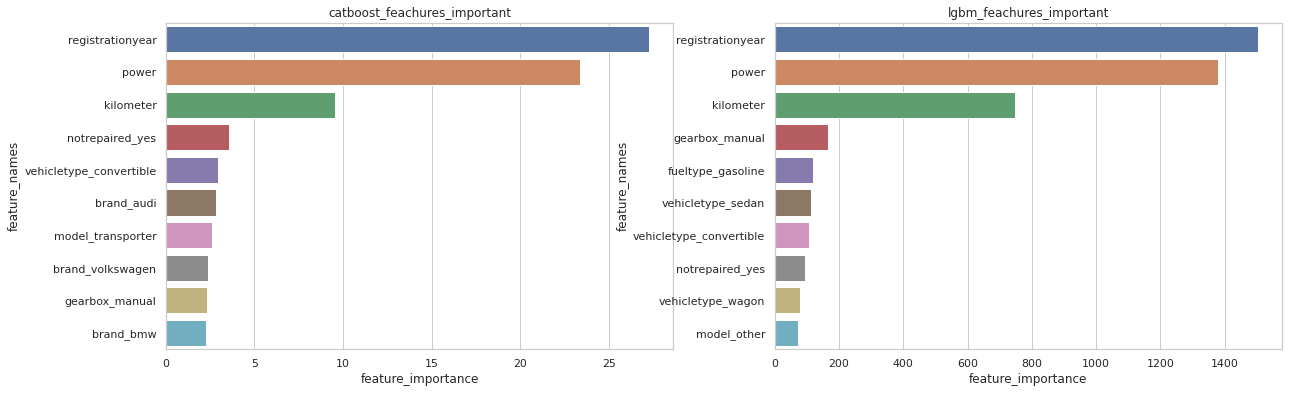

In [129]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(1,2, figsize=(20, 6))

sns.barplot(ax=axes[0],
    data=catboost_feachures_important,
    x="feature_importance", y="feature_names").set(title='catboost_feachures_important')

sns.barplot(ax=axes[1], 
    data=lgbm_feachures_important,
    x="feature_importance", y="feature_names").set(title='lgbm_feachures_important')



График топ 10 значимых факторов моделей catboost и  lgbm. Совпадение только по признаку года регистрации, в остальном модели совершенно по разному определили значимость признаков. И кажеться что модель lgbm сделала это лучше. 

### Итоговый  результат

In [130]:
results = pd.DataFrame()

In [131]:
results = results.append(catboost_clear,ignore_index=True)

In [132]:
results = results.append(lgbm,ignore_index=True)

In [133]:
results = results.append(lin_r,ignore_index=True)

In [134]:
results

,fit_score,fit_time,grid_score,grid_time,model,predict_time,result_score
0,1526.289733,0:00:34.463098,1483.690506,0:01:44.376627,Catboost,0:00:00.126386,1526.289733
1,1770.726452,0:00:03.041923,1770.726452,0:00:23.930217,LGBMRegressor,0:00:00.355589,1533.290406
2,NaN,0:00:01.048494,2513.535909,0:00:07.807159,LinearRegression,0:00:00.043461,2508.709495


## Чек-лист проверки

Полученные данные были очищены от выбросов, удалены лишние признаки, не несущие в себе никакой значимости для предсказания целевого признака.
После первоначальной обработки было сформированно два датасет для обучения моделей. Оба датасета сократились порядка на 40 000 событий.
1. Датасет в котором все пропуски были заменены на "other", размер датасета остался не изменым после первого этапа обработки
2. Датасет был полностью очищен от событий с пропусками, размер сократился еще порядка на 15 процентов от этапа обработки

В таком виде выборки были переданы на второй этап - обучение моделей, и выбора датасета для тестирования и обучения.
В качестве первой модели обучения была модель catboostRegressor, с ее помощью предполагалось выбрать наилучший датасет.
После первых попыток, в выборках были перекодированы категориальные признаки, что ускорило время обучения.

Для моделей lgbm, catboost для проверки использовалась тестовая выборка.

Подбор гиперпараметров для моделей catboost подбирался методом gred_search.  
Для модели LGBMRegressor гиперпараметры подбирались с помощью GridSearchCV

По полученным параметрам, с небольшим отрывом от показателей модели lgbm, нобольшим по времени обучения , лучшей показала себя модельcatboost.

Так же хочу добавить следующще. Текущий датасет содержит в себе множество катеогрий автомобилей, предпологаю, что добиться еще лучшего рещультата можено путем создания для каждой категории ТС отдельной модели.